In [1]:
from scipy import stats
pd.set_option('mode.chained_assignment',  None) 

### Figure 2

Read data

In [2]:
files = ["../data/Figure2ab_Data_ru.csv", 
         "../data/Figure2c_Data.csv"]
dat = []
for f in files:
    sep = "\t" if f.endswith("tsv") else ","
    df = pd.read_csv(f, sep=sep)
    df = df.rename(columns = {c:c.replace("Boostrap", "Bootstrap") 
                              for c in df.columns if "Boos" in c})
    dat.append(df)   
    
#dat[1]["Distance"] = dat[0].Distance

In [3]:
coef = pd.read_csv("../data/Figure2c_Data.tsv",sep="\t")
coef = coef.iloc[::-1].reset_index(drop=True)

Plot figures

<ipython-input-6-83e6f594914d>:141: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs['E'].get_shared_x_axes().join(axs['E'], axs['D'])


pvalue 0.656686626746507 329 501
34.4
pvalue 0.001996007984031936 1 501
100.0


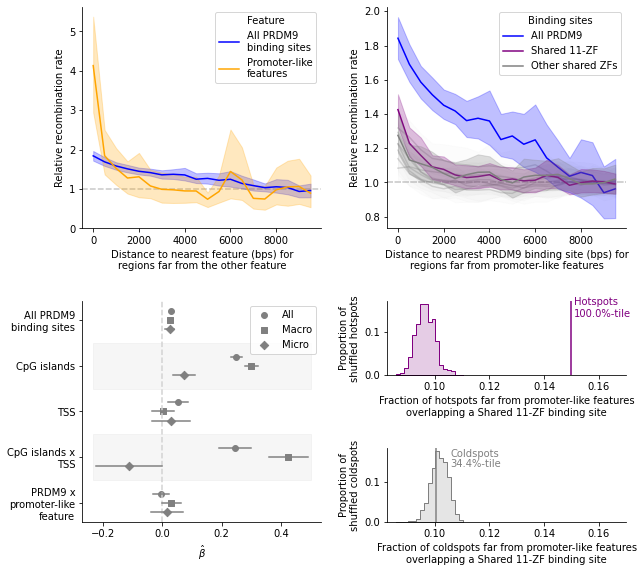

In [6]:
mosaic = '''
AB
AB
CD
CE
'''
f, axs = plt.subplot_mosaic(mosaic,
                            figsize=[9,8])


# Panel A
idx = 0
ax = axs["A"]
tdf = dat[idx]
handles = []
bl = "blue"
palette = {"prdm9_all":bl, 
           "promoters":"orange"}
x = "distance"
y = "norm_mean"
y_lw = "norm_low_ci"
y_hg = "norm_high_ci"

for feature, color in palette.items():
        
    df = tdf[tdf.kind==feature]
    norm = df[df.distance.between(8e3,10e3)]["mean"].mean()
    for p in ["mean", "low_ci", "high_ci"]:
        df[f"norm_{p}"] = np.where((df[p] < 1e9), df[p]/norm, df[p])
        
    sns.lineplot(data=df, 
                 x=x, y=y, 
                 c=color,                 
                 ax=ax,                                          
                 label=feature)
    
    handles.append(plt.Line2D([], [], 
                              color=color, 
                              label=feature))
    
    ax.fill_between(df[x], 
                    df[y_lw], 
                    df[y_hg], 
                    color=color, 
                    alpha=0.25)
    
    ax.axhline(y=1, 
               linestyle="dashed", 
               color="lightgray", 
               zorder=0)
    
    ax.set_xlabel("Distance to nearest feature (bps) for\nregions far from the other feature")
    ax.set_ylabel("Relative recombination rate")

ax.legend(handles = handles, title="Feature",
          frameon=True,
          labels = ["All PRDM9\nbinding sites", "Promoter-like\nfeatures"])

ax.set_ylim(bottom = 0)
# Panel B
idx = 1
ax = axs["B"]
tdf = dat[0]

paletteB = {"prdm9_all":bl, "KmerZFs_11_0":"purple", "KmerZFs_7_0":"gray"}
sel_kmers = list(paletteB.keys())
label_dict = {"prdm9_all": "All PRDM9", "KmerZFs_11_0":"Shared 11-ZF",'KmerZFs_7_0': "Other shared ZFs" }#\nbinding sites
kmers = [c for c in tdf.kind.unique() if "prom" not in c]
kmer_colors = ["gray" for i,c in enumerate(sns.color_palette("tab10", 11)) if i not in [0,4]]

i = 0
for k in kmers:
    if k not in paletteB:
        paletteB[k] = kmer_colors[i]
        i += 1

for feature, color in paletteB.items():
    
    df = tdf[tdf.kind==feature]
    norm = df[df.distance.between(8e3,10e3)]["mean"].mean()
    for p in ["mean", "low_ci", "high_ci"]:
        df[f"norm_{p}"] = np.where((df[p] < 1e9), df[p]/norm, df[p])

    sns.lineplot(data=df, 
                 x=x, y=y, 
                 c=color,                 
                 ax=ax,
                 alpha =1 if feature in sel_kmers else 0.3,
                 label=label_dict[feature] if feature in sel_kmers else "",
                 zorder=10 if feature in sel_kmers else 1)

    handles.append(plt.Line2D([], [], 
                              color=color, 
                              label=feature))

    ax.fill_between(df[x], 
                    df[y_lw], 
                    df[y_hg], 
                    color=color, 
                    alpha=0.25 if feature in sel_kmers else 0.02, 
                    zorder=10 if feature in sel_kmers else 1)

    ax.axhline(y=1, 
               linestyle="dashed", 
               color="lightgray", 
               zorder=0)

ax.legend(frameon=True, title="Binding sites")
ax.set_xlabel("Distance to nearest PRDM9 binding site (bps) for\nregions far from promoter-like features")
ax.set_ylabel("Relative recombination rate")

# Panel C
ax = axs["C"]
ax.axvline(x=0, color="lightgray", linestyle="dashed")
colors = ["black", "gray", "lightgray"]

maxv = coef[[c for c in coef.columns if c!="Name"]].max().max() + 0.01
minv = coef[[c for c in coef.columns if c!="Name"]].min().min() - 0.01
xs = np.linspace(minv, maxv, 10)

margins = [-0.2,0,0.2]
shapes = ["D", "s", "o"]
for i,t in enumerate(["All", "Macro", "Micro"][::-1]):
    color = "gray" #f"C{i}" #colors[i]
    ax.scatter(coef[t], coef.index+margins[i], c=color, s=35, label=t, marker=shapes[i])
    for y,r in coef.iterrows():
        ax.plot([r[f"{t}_975"], r[f"{t}_025"]], 
                [y+margins[i],y+margins[i]], c=color)

for i in range(len(coef)):
    if i%2!=0:
        ax.fill_between(xs, i-0.5, i+0.5, color="lightgray", zorder=0, alpha=0.2)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.set_xlabel(r"$\hat{\beta}$")
ax.set_yticks(coef.index)
labels = ["All PRDM9\nbinding sites", "CpG islands", "TSS", "CpG islands x\nTSS", "PRDM9 x\npromoter-like\nfeature"][::-1]
ax.set_yticklabels(labels)

axs['E'].get_shared_x_axes().join(axs['E'], axs['D'])
# Panel D
idx = 2
ax = axs["E"]
df = dat[-1]
shuf = df[df.kind!="original"]
orig = df[df.kind=="original"]

spots = ["coldspots"]
labels = ["Overlap with PRDM9 binding sites\n(>10kb from CpG island)", 
          "Overlap with CpG islands\n(>10kb from a PRDM9 binding site)"]

palettes = {"prdm9_cond":{"hotspots":"purple", "coldspots":"gray"}}

for i,v in enumerate(["prdm9_cond"]):
    g = sns.histplot(data=shuf, x=v,
                     hue="spot", 
                     hue_order=spots,
                     palette = palettes[v],
                     element="step",stat="probability", 
                     common_norm=False,
                     bins = 17,
                     alpha = 0.2,
                     legend = False,
                     ax=ax)

    for isp,sp in enumerate(spots):
        o = orig[orig.spot==sp][v].values[0]
        sh = shuf[shuf.spot==sp]
        perc = stats.percentileofscore(sh[v], o, kind="strict")
        r = sum([1 for u in list(sh[v]) + [o] if u>=o])
        n = len(sh[v])+1
        pval = r/n
        print("pvalue", r/n, r, n)
        print(perc)
        ax.axvline(x=o, c=palettes[v][sp])
        marg = 5e-3 if "cold" in sp else 1e-3
        ax.annotate(sp.capitalize(), 
                    xy=(o+marg, 0.163), 
                    color=palettes[v][sp])
        ax.annotate("{:.1f}%-tile".format(perc), 
                    xy=(o+marg, 0.136), 
                    color=palettes[v][sp])
ax.set_xlabel("Fraction of coldspots far from promoter-like features\noverlapping a Shared 11-ZF binding site")
ax.set_ylabel("Proportion of\nshuffled coldspots")

# Panel E
idx = 2
ax = axs["D"]
df = dat[-1]
shuf = df[df.kind!="original"]
orig = df[df.kind=="original"]

spots = ["hotspots"]
labels = ["Overlap with PRDM9 binding sites\n(>10kb from CpG island)", 
          "Overlap with CpG islands\n(>10kb from a PRDM9 binding site)"]

palettes = {"prdm9_cond":{"hotspots":"purple", "coldspots":"gray"}}

for i,v in enumerate(["prdm9_cond"]):
    g = sns.histplot(data=shuf, x=v,
                     hue="spot", 
                     hue_order=spots,
                     palette = palettes[v],
                     element="step",stat="probability", 
                     common_norm=False,
                     bins = 17,
                     alpha = 0.2,
                     legend = False,
                     ax=ax)

    for isp,sp in enumerate(spots):
        o = orig[orig.spot==sp][v].values[0]
        sh = shuf[shuf.spot==sp]
        perc = stats.percentileofscore(sh[v], o, kind="strict")
        r = sum([1 for u in list(sh[v]) + [o] if u>=o])
        n = len(sh[v])+1
        pval = r/n
        print("pvalue", r/n, r, n)
        print(perc)
        ax.axvline(x=o, c=palettes[v][sp])
        marg = 2e-3 if "cold" in sp else 1e-3
        ax.annotate(sp.capitalize(), 
                    xy=(o+marg, 0.163), 
                    color=palettes[v][sp])
        ax.annotate("{:.1f}%-tile".format(perc), 
                    xy=(o+marg, 0.136), 
                    color=palettes[v][sp])


ax.set_xlim(right=0.17)
ax.set_xlabel("Fraction of hotspots far from promoter-like features\noverlapping a Shared 11-ZF binding site")
ax.set_ylabel("Proportion of\nshuffled hotspots")

panel_letters = ['A', 'B', 'C']

pos_D = axs['D'].get_position()
pos_E = axs['E'].get_position()

# Set new positions
# Here we are moving E closer to D by adjusting the y0 position of E
# This example assumes 'E' is below 'D', so we decrease the y0 of E to move it upwards
desired_gap = 0.0001
axs['E'].set_position([pos_E.x0, pos_D.y0 - pos_E.height - desired_gap, pos_E.width, pos_E.height])

sns.despine()
plt.tight_layout()
#plt.tight_layout(pad=0.4, h_pad=1, w_pad=0.1)
plt.savefig("../pdfs/Figure2.pdf")

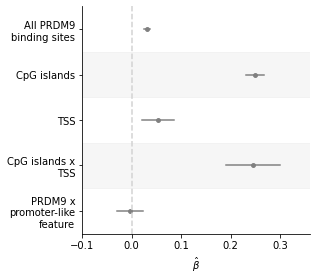

In [7]:
f,ax = plt.subplots(figsize=[4.5,4])
ax.axvline(x=0, color="lightgray", linestyle="dashed")
colors = ["black", "gray", "lightgray"]

maxv = coef[[c for c in coef.columns if c!="Name"]].max().max() + 0.01
minv = coef[[c for c in coef.columns if c!="Name"]].min().min() - 0.01
xs = np.linspace(minv, maxv, 10)

margins = [-0.2,0,0.2]
shapes = ["D", "s", "o"]
color = "gray" #f"C{i}" #colors[i]
i = 1
ax.scatter(coef[t], coef.index+margins[i], c=color, s=15, label=t)
for y,r in coef.iterrows():
    ax.plot([r[f"{t}_975"], r[f"{t}_025"]], 
            [y+margins[i],y+margins[i]], c=color)

for i in range(len(coef)):
    if i%2!=0:
        ax.fill_between(xs, i-0.5, i+0.5, color="lightgray", zorder=0, alpha=0.2)

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1])
ax.set_xlabel(r"$\hat{\beta}$")
ax.set_ylim([-0.5,4.5])
ax.set_xlim([-0.1, 0.36])
ax.set_yticks(coef.index)
labels = ["All PRDM9\nbinding sites", "CpG islands", "TSS", "CpG islands x\nTSS", "PRDM9 x\npromoter-like\nfeature"][::-1]
ax.set_yticklabels(labels)
plt.tight_layout()
sns.despine()
#plt.savefig("../pdfs/coefs_all.pdf")

In [9]:
files = ["../data/Figure2ab_Data_ru_pyrho.csv", 
         "../data/Figure2c_Data.csv"]
dat = []
for f in files:
    sep = "\t" if f.endswith("tsv") else ","
    df = pd.read_csv(f, sep=sep)
    df = df.rename(columns = {c:c.replace("Boostrap", "Bootstrap") 
                              for c in df.columns if "Boos" in c})
    dat.append(df)  
coef = pd.read_csv("../data/Pyrho_Model_Data.tsv",sep="\t")
coef = coef.iloc[::-1].reset_index(drop=True)

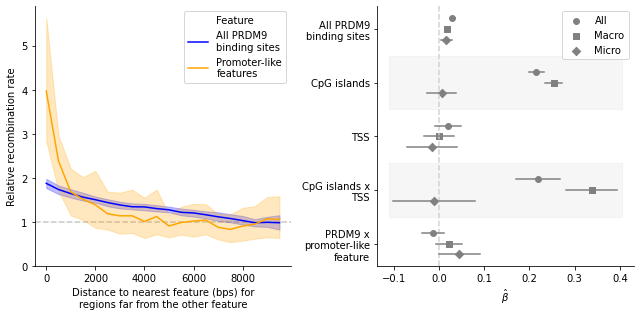

In [10]:
f,axs = plt.subplots(1,2, figsize=[9,4.5])


# Panel A
idx = 0
ax = axs[0]
tdf = dat[idx]
handles = []
bl = "blue"
palette = {"prdm9_all":bl, 
           "promoters":"orange"}
x = "distance"
y = "norm_mean"
y_lw = "norm_low_ci"
y_hg = "norm_high_ci"

for feature, color in palette.items():
        
    df = tdf[tdf.kind==feature]
    norm = df[df.distance.between(8e3,10e3)]["mean"].mean()
    for p in ["mean", "low_ci", "high_ci"]:
        df[f"norm_{p}"] = np.where((df[p] < 1e9), df[p]/norm, df[p])
        
    sns.lineplot(data=df, 
                 x=x, y=y, 
                 c=color,                 
                 ax=ax,                                          
                 label=feature)
    
    handles.append(plt.Line2D([], [], 
                              color=color, 
                              label=feature))
    
    ax.fill_between(df[x], 
                    df[y_lw], 
                    df[y_hg], 
                    color=color, 
                    alpha=0.25)
    
    ax.axhline(y=1, 
               linestyle="dashed", 
               color="lightgray", 
               zorder=0)
    
    ax.set_xlabel("Distance to nearest feature (bps) for\nregions far from the other feature")
    ax.set_ylabel("Relative recombination rate")

ax.legend(handles = handles, title="Feature",
          frameon=True,
          labels = ["All PRDM9\nbinding sites", "Promoter-like\nfeatures"])

ax.set_ylim(bottom = 0)

# Panel B
ax = axs[1]
ax.axvline(x=0, color="lightgray", linestyle="dashed")
colors = ["black", "gray", "lightgray"]

maxv = coef[[c for c in coef.columns if c!="Name"]].max().max() + 0.01
minv = coef[[c for c in coef.columns if c!="Name"]].min().min() - 0.01
xs = np.linspace(minv, maxv, 10)

margins = [-0.2,0,0.2]
shapes = ["D", "s", "o"]
for i,t in enumerate(["All", "Macro", "Micro"][::-1]):
    color = "gray" #f"C{i}" #colors[i]
    ax.scatter(coef[t], coef.index+margins[i], c=color, s=35, label=t, marker=shapes[i])
    for y,r in coef.iterrows():
        ax.plot([r[f"{t}_975"], r[f"{t}_025"]], 
                [y+margins[i],y+margins[i]], c=color)

for i in range(len(coef)):
    if i%2!=0:
        ax.fill_between(xs, i-0.5, i+0.5, color="lightgray", zorder=0, alpha=0.2)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.set_xlabel(r"$\hat{\beta}$")
ax.set_yticks(coef.index)
labels = ["All PRDM9\nbinding sites", "CpG islands", "TSS", "CpG islands x\nTSS", "PRDM9 x\npromoter-like\nfeature"][::-1]
ax.set_yticklabels(labels)

sns.despine()
plt.tight_layout()
#plt.savefig("../pdfs/FigureS7.pdf")
#plt.savefig("../pdfs/FigureS7.jpg", dpi=400)